In [1]:
import os
import logging
import random
import gc
import time
import cv2
import math
import warnings
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import librosa

from sklearn.metrics import roc_auc_score, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
import timm

from importlib import reload

logging.basicConfig(level=logging.ERROR)

from module import preprocess_lib, datasets_lib, utils_lib, models_lib, learning_lib, config_lib
reload(config_lib)

<module 'module.config_lib' from '/root/program/birdclef-2025/scripts/module/config_lib.py'>

In [2]:


class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            
            self.spectrogram_npy = '../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy'
            
            self.pseudo_label_csv = "../data/result/pseudo_labels_baseline_7sec.csv"
            self.pseudo_melspec_npy = "../data/processed/train_soundscapes_0407/train_soundscapes_melspecs.npy"

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5.0 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 512
        self.N_MELS = 128
        self.FMIN = 50
        self.FMAX = 14000        

        # ===== Training Mode =====
        if mode == "train":
            self.seed = 42
            self.apex = False
            self.print_freq = 100
            self.num_workers = 2

            self.LOAD_DATA = True
            self.epochs = 10
            self.batch_size = 516
            self.criterion = 'BCEWithLogitsLoss'

            self.n_fold = 5
            self.selected_folds = [0, 1, 2, 3, 4]

            self.optimizer = 'AdamW'
            self.lr = 5e-4
            self.weight_decay = 1e-5
            self.scheduler = 'CosineAnnealingLR'
            self.min_lr = 1e-6
            self.T_max = self.epochs

            self.aug_prob = 0.5
            self.mixup_alpha_real = 0.5
            self.mixup_alpha_pseudo = 0.5
            
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
            self.use_pseudo_mixup = False  # pseudo lableでmixupするかどうか
            self.pseudo_mix_prob = 0.4  # mixupでpseudo lableを使う確率
            self.pseudo_conf_threshold = 0.5
            

            if self.debug:
                self.epochs = 2
                self.selected_folds = [0]
                self.batch_size = 4
                

In [3]:
# debug trueにするとvalidationの数が1000に固定される．
cfg = CFG(mode="train", kaggle_notebook=False, debug=False)

In [4]:
utils_lib.set_seed(cfg.seed)

In [5]:
spec = np.load("../data/processed/mel_cleaned_0413//birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()
train = pd.read_csv("../data/processed/mel_cleaned_0413/train.csv")

In [36]:
def compute_combined_loss_df(base_dir, fold_ids=[0, 1, 2, 3, 4]):
    all_loss_dfs = []

    for fold in fold_ids:
        pred_path = os.path.join(base_dir, f"predictions_fold{fold}.csv")
        target_path = os.path.join(base_dir, f"targets_fold{fold}.csv")

        # 読み込み
        predictions = pd.read_csv(pred_path)
        targets = pd.read_csv(target_path)

        row_ids = predictions["row_id"]
        preds = predictions.drop(columns=["row_id"]).values
        true = targets.drop(columns=["row_id"]).values

        # loss計算
        epsilon = 1e-7
        bce = - (true * np.log(preds + epsilon) + (1 - true) * np.log(1 - preds + epsilon))
        sample_loss = bce.mean(axis=1)

        # positiveラベル数
        num_positive = true.sum(axis=1)

        # DataFrame化
        loss_df = pd.DataFrame({
            "row_id": row_ids,
            "sample_loss": sample_loss,
            "num_positive_labels": num_positive,
            "fold": fold
        })

        all_loss_dfs.append(loss_df)

    # 統合
    combined_loss_df = pd.concat(all_loss_dfs, ignore_index=True)
    combined_loss_df = combined_loss_df.sort_values(by="sample_loss", ascending=False).reset_index(drop=True)

    return combined_loss_df


def plot_melspectrogram(spec: dict, species_id: str, 
                        fmin: int = 50, fmax: int = 16000, 
                        duration: float = 5.0,
                        figsize=(6, 4), cmap='magma'):

    if species_id not in spec:
        print(f"[ERROR] '{species_id}' not found in spec!")
        return

    mel = spec[species_id]  # shape: (n_mels, time_steps)
    extent = [0, duration, fmin, fmax]

    plt.figure(figsize=figsize)
    plt.imshow(mel, aspect='auto', origin='lower', cmap=cmap, extent=extent)
    plt.title(f"MelSpectrogram of {species_id}")
    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label='Amplitude')
    plt.tight_layout()
    plt.show()

In [16]:
loss_df = compute_combined_loss_df("../models/mel_cleaned0413")
loss_df.head(10)

,row_id,sample_loss,num_positive_labels,fold
0,olipic1/XC561651.ogg,0.256099,6.0,3
1,yebela1/XC913479.ogg,0.204685,5.0,3
2,whtdov/XC703709.ogg,0.175123,10.0,3
3,bubwre1/XC395982.ogg,0.174925,5.0,3
4,paltan1/XC708161.ogg,0.174168,6.0,2
5,blcjay1/XC319947.ogg,0.169229,6.0,0
6,leagre/XC619321.ogg,0.159301,6.0,3
7,mastit1/XC353967.ogg,0.158421,6.0,4
8,ruther1/XC708492.ogg,0.158282,5.0,1
9,ywcpar/XC537086.ogg,0.158232,5.0,3


In [46]:
loss_df[loss_df["row_id"].str.contains("bubwre1")].head(10)

,row_id,sample_loss,num_positive_labels,fold
3,bubwre1/XC395982.ogg,0.174925,5.0,3
30,bubwre1/XC777742.ogg,0.114269,3.0,4
182,bubwre1/XC906410.ogg,0.068256,2.0,3
363,bubwre1/XC286984.ogg,0.054482,3.0,4
400,bubwre1/XC777936.ogg,0.052768,2.0,0
461,bubwre1/XC243820.ogg,0.050257,3.0,0
484,bubwre1/XC695955.ogg,0.049641,4.0,4
526,bubwre1/XC400558.ogg,0.048148,4.0,4
539,bubwre1/XC827255.ogg,0.047856,1.0,1
560,bubwre1/iNat714007.ogg,0.047326,1.0,2


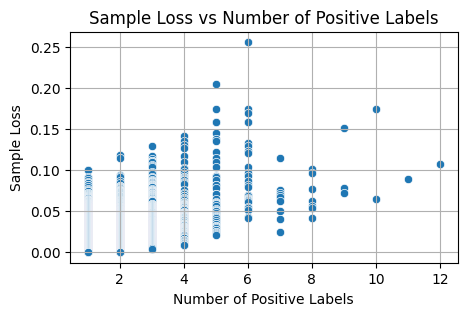

In [18]:
# num_positive_labelsとsample lossの関係をプロット
# labelが多いほうがlossが大きい
plt.figure(figsize=(5, 3))
sns.scatterplot(data=loss_df, x="num_positive_labels", y="sample_loss")
plt.title("Sample Loss vs Number of Positive Labels")
plt.xlabel("Number of Positive Labels")
plt.ylabel("Sample Loss")
plt.grid()
plt.show()

In [31]:
# num_positive_labelsが1のものを抽出
i = 0
hard_filename = loss_df[loss_df["num_positive_labels"] == 1]["row_id"].values[i]
train[train["filename"] == hard_filename]

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
12869,leagre,[''],[''],leagre/iNat352402.ogg,iNat,0.0,https://static.inaturalist.org/sounds/352402.wav,29.3706,-95.6272,Tachybaptus dominicus,...,leagre-iNat352402,Aves,center,13.922937,0,13.922937,0,False,leagre-iNat352402,4


In [32]:
label = train[train["filename"] == hard_filename]["primary_label"].values[0]
df = train[train["primary_label"] == label]
print(df.shape)
df.head()

(108, 25)


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
12772,leagre,[''],['call'],leagre/XC123982.ogg,XC,4.0,https://xeno-canto.org/123982,-18.1206,-63.6471,Tachybaptus dominicus,...,leagre-XC123982,Aves,center,4.571438,0,4.571438,0,False,leagre-XC123982,0
12773,leagre,[''],['chatter'],leagre/XC123988.ogg,XC,4.0,https://xeno-canto.org/123988,-18.1206,-63.6471,Tachybaptus dominicus,...,leagre-XC123988,Aves,center,11.311031,0,11.311031,0,False,leagre-XC123988,1
12774,leagre,[''],['call'],leagre/XC132052.ogg,XC,5.0,https://xeno-canto.org/132052,14.5490,-86.8497,Tachybaptus dominicus,...,leagre-XC132052,Aves,center,20.136000,0,20.136000,0,False,leagre-XC132052,2
12775,leagre,[''],['call'],leagre/XC149805.ogg,XC,4.0,https://xeno-canto.org/149805,-24.0458,-52.3828,Tachybaptus dominicus,...,leagre-XC149805,Aves,center,26.697156,0,26.697156,0,False,leagre-XC149805,3
12776,leagre,['whwswa1'],['call'],leagre/XC153567.ogg,XC,3.5,https://xeno-canto.org/153567,-17.7833,-63.0666,Tachybaptus dominicus,...,leagre-XC153567,Aves,center,7.392656,0,7.392656,0,False,leagre-XC153567,4


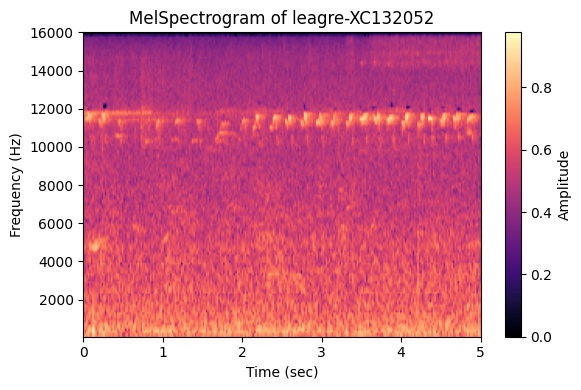

In [47]:
filename = "leagre/XC132052.ogg"
samplename= train[train["filename"] == filename]["samplename"].values[0]
# 表示
plot_melspectrogram(spec, samplename)
utils_lib.play_audio(filename, cfg.train_datadir)

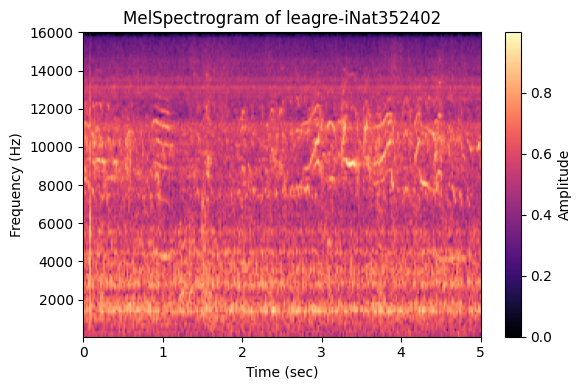

In [ ]:
# 表示したい species_id を指定（例: 'pitangsp'）
samplename= train[train["filename"] == hard_filename]["samplename"].values[0]
# 表示
plot_melspectrogram(spec, samplename)
utils_lib.play_audio(hard_filename, cfg.train_datadir)

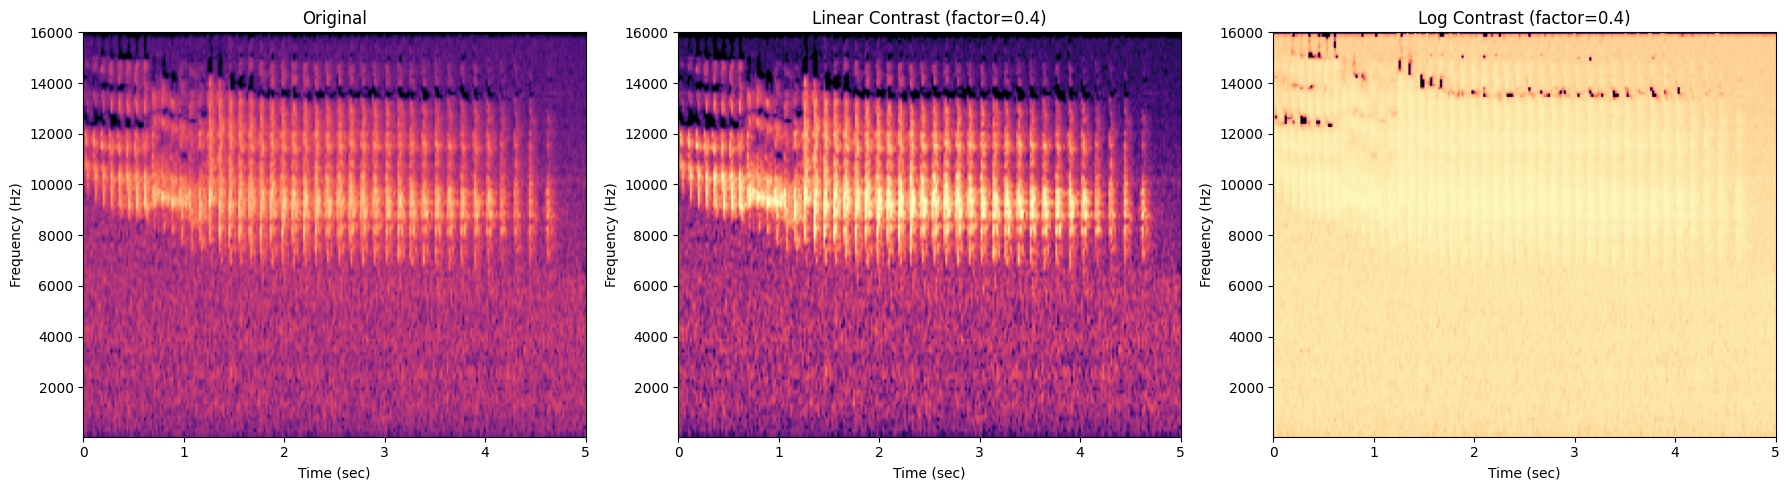

In [61]:

def enhance_spectrogram_contrast_linear(spec, factor=0.15):
    """
    線形のコントラスト強調：meanとの差分を拡張
    """
    mean = np.mean(spec)
    enhanced = mean + (spec - mean) * (1 + factor)
    return np.clip(enhanced, 0, 1)

def enhance_spectrogram_contrast_log_safe(spec, factor=0.15):
    """
    より安定した log スケーリング + コントラスト強調
    """
    log_spec = np.log10(spec + 1e-6)

    # コントラスト強調（平均中心化）
    mean = np.mean(log_spec)
    enhanced = mean + (log_spec - mean) * (1 + factor)

    # 実用的な表示のために [-3, 0] の範囲を前提に正規化（適宜調整可）
    normalized = (enhanced + 3) / 3  # [-3, 0] → [0, 1]

    return np.clip(normalized, 0, 1)

def show_spectrogram_contrast_comparison(spec, factor=0.15, log_base=10, fmin=50, fmax=16000, duration=5.0):
    """
    オリジナル / 線形強調 / log強調 の比較表示
    """
    extent = [0, duration, fmin, fmax]

    enhanced_linear = enhance_spectrogram_contrast_linear(spec, factor)
    enhanced_log = enhance_spectrogram_contrast_log(spec, log_base, factor)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    axs[0].imshow(spec, aspect='auto', origin='lower', cmap='magma', extent=extent)
    axs[0].set_title("Original")
    
    axs[1].imshow(enhanced_linear, aspect='auto', origin='lower', cmap='magma', extent=extent)
    axs[1].set_title(f"Linear Contrast (factor={factor})")

    axs[2].imshow(enhanced_log, aspect='auto', origin='lower', cmap='magma', extent=extent)
    axs[2].set_title(f"Log Contrast (factor={factor})")

    for ax in axs:
        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("Frequency (Hz)")
    
    plt.tight_layout()
    plt.show()
    
species_id = "amakin1-XC306297"
mel = spec[species_id]
show_spectrogram_contrast_comparison(mel, factor=0.4)


In [ ]:
# 信頼性がない予測値

from scipy.stats import entropy
import numpy as np
import pandas as pd

# row_id を取り出す
row_ids = predictions["row_id"]

# 確率値を NumPy array に
preds = predictions.drop(columns=["row_id"]).values

# --- ① max confidence (自信のあるラベルがないサンプルを検出)
max_confidence = preds.max(axis=1)  # 各サンプルで最大の予測値

# --- ② エントロピー（曖昧さの指標）
entropy_scores = entropy(preds, axis=1)  # axis=1 → 各サンプルごとにエントロピー計算

# --- 結果をまとめる
uncertainty_df = pd.DataFrame({
    "row_id": row_ids,
    "max_confidence": max_confidence,
    "entropy": entropy_scores
})

# 確信度が低い順（曖昧な順）に並べ替え
uncertainty_df = uncertainty_df.sort_values(by="max_confidence", ascending=True).reset_index(drop=True)


,row_id,max_confidence,entropy
0,cattyr/XC318581.ogg,0.029015,4.246751
1,cocwoo1/XC338418.ogg,0.029494,2.734630
2,bicwre1/XC152232.ogg,0.032167,3.291070
3,41663/iNat722167.ogg,0.032939,3.224321
4,shtfly1/XC830340.ogg,0.034673,3.865061
5,50186/CSA20037.ogg,0.034756,4.089189
6,whtdov/XC257620.ogg,0.035642,3.686739
7,bobfly1/XC549946.ogg,0.037735,4.253721
8,strcuc1/iNat332901.ogg,0.037770,4.361690
9,yeofly1/XC120031.ogg,0.039142,4.516472


In [158]:
i = 6
hard_filename = uncertainty_df["row_id"].values[i]
train[train["filename"] == hard_filename]

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
25425,whtdov,[''],['song'],whtdov/XC257620.ogg,XC,5.0,https://xeno-canto.org/257620,-0.504,-76.406,Leptotila verreauxi,...,whtdov-XC257620,Aves,center,16.561625,0,16.561625,0,False,whtdov-XC257620,1


In [159]:
label = train[train["filename"] == hard_filename]["primary_label"].values[0]
train[train["primary_label"] == label].shape

(572, 25)

In [160]:
utils_lib.play_audio(hard_filename, cfg.train_datadir)

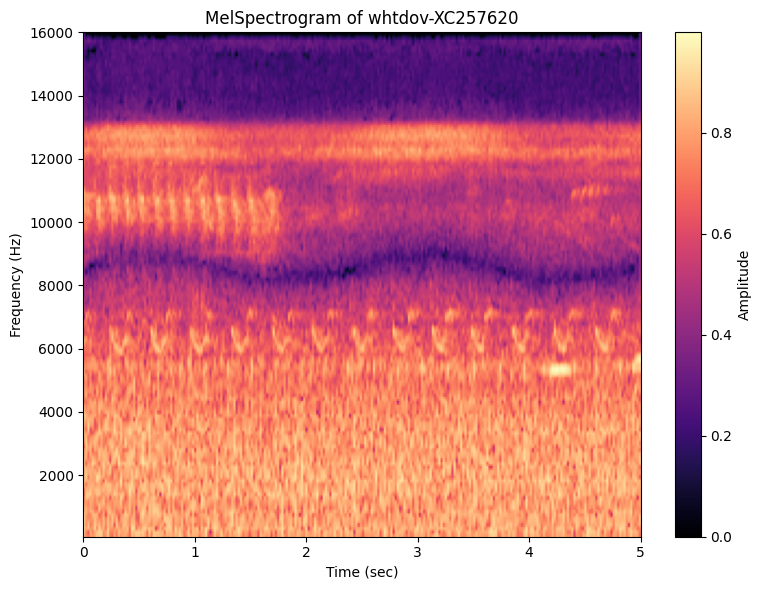

In [161]:


# 表示したい species_id を指定（例: 'pitangsp'）
samplename= train[train["filename"] == hard_filename]["samplename"].values[0]
species_id = samplename # 実際のIDに置き換えてください

# Melスペクトログラムを取得
mel = spec[species_id]  # shape: (256, 256)

n_mels = 148  # 例: 256
fmin = 50           # 実際に使用したfmin
fmax = 16000           # 実際に使用したfmax
duration = 5.0         # メルスペクトログラムの時間（秒）

# X軸（時間）と Y軸（周波数）の範囲指定
extent = [0, duration, fmin, fmax]  # [x_min, x_max, y_min, y_max]

# 表示
plt.figure(figsize=(8, 6))
plt.imshow(mel, aspect='auto', origin='lower', cmap='magma', extent=extent)
plt.title(f"MelSpectrogram of {species_id}")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()